In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pyod.models.hbos import HBOS
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from pyod.models.loda import LODA
from pyod.models.copod import COPOD

In [2]:
plt.style.use('seaborn-dark')

<b>UGR DATASET</b>

In [3]:
#Set column names and datatypes
column_names = [
    'timestamp', 'duration', 'source_ip', 'dst_ip', 'source_port', 'dst_port',
    'protocol', 'flags', 'forward_status', 'type_of_service', 'packets', 'bytes', 'type'
]
dtypes = {
    #'timestamp': datetime,
    'duration': float,
    'source_ip': str,
    'dst_ip': str,
    'source_port': int,
    'dst_port': int,
    'protocol': str,
    'flags': str,
    'forward_status': int,
    'type_of_service': int,
    'packets': int,
    'bytes': int,
    'type': str
}

In [4]:
#Read the source csv file for UGR16'
df = pd.read_csv('./data/training/uniq/20160318.csv', header=None, names=column_names, dtype=dtypes, parse_dates=[0])

In [5]:
#Create a copy of loaded dataframe for safe modifications
df_copy = df.copy()

In [6]:
#Group the dataframe by hour and mintue
df_group = df_copy.groupby([df['timestamp'].dt.hour, df['timestamp'].dt.minute]).agg(['count'])

In [7]:
#Compare size of dataset before and after the grouping operation
print(df_copy.shape)
print(df_group.shape)

(39990810, 13)
(788, 13)


In [8]:
#Set chart axes
xaxis = np.arange(df_group.shape[0])
yaxis = df_group['timestamp'].values[:,0]

In [9]:
#df_group.head(10)

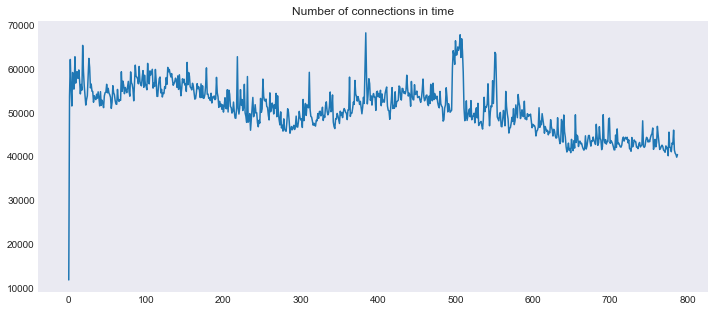

In [10]:
#Plot # of flows
fig = plt.figure(figsize=(12, 5))
plt.plot(xaxis, yaxis)
plt.title('Number of connections in time')
plt.show()

In [11]:
#Set model parameters
outlier_fraction = 0.1
X1 = xaxis.reshape(-1, 1)
X2 = yaxis.reshape(-1, 1)
X_train = np.concatenate((X1, X2), axis=1)
X_train.shape

(788, 2)

In [12]:
#Define models and their params for outlier detection
classifiers = {
    'Histogram-Based Outlier Score': HBOS(contamination=outlier_fraction),
    'k Nearest Neighbors': KNN(contamination=outlier_fraction),
    #'Average kNN': KNN(method='mean', contamination=outlier_fraction),
    'Clustering Based Local Outlier Factor': CBLOF(contamination=outlier_fraction),
    #'Lightweight On-line Detection of Anomalies': LODA(contamination=outlier_fraction),
    #'Copula Based Outlier Detector': COPOD(contamination=outlier_fraction)
}

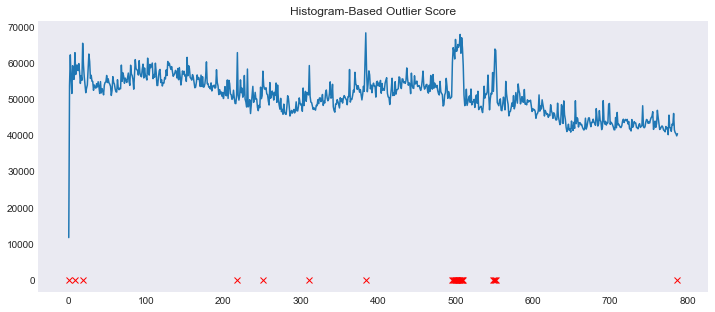

Detection type: Histogram-Based Outlier Score
# of steps: 788
# of detected anomalies: 27
% of detected anomalies: 3.43%


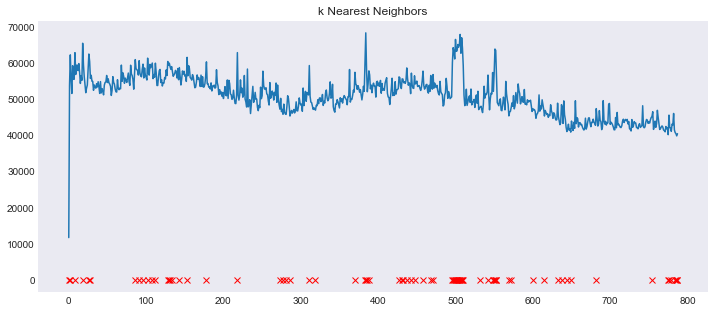

Detection type: k Nearest Neighbors
# of steps: 788
# of detected anomalies: 79
% of detected anomalies: 10.03%


c:\users\kuba\python\network-anomaly-detection\venv\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


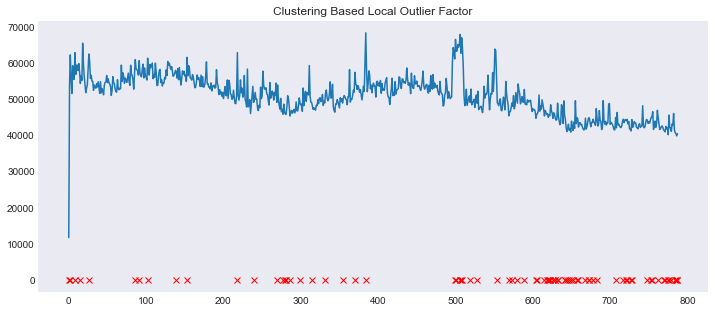

Detection type: Clustering Based Local Outlier Factor
# of steps: 788
# of detected anomalies: 79
% of detected anomalies: 10.03%


In [13]:
classifier_scores = {}
for clf_name, clf in classifiers.items():
    clf.fit(X_train)
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    scatter = pd.DataFrame([xaxis, y_train_pred]).T
    logicalscatter = scatter[scatter[1] > 0]
    fig = plt.figure(figsize=(12, 5))
    plt.title(clf_name)
    plt.plot(xaxis, yaxis)
    plt.scatter(logicalscatter[0], logicalscatter[1], c='red', marker='x', linewidths=1)
    plt.show()
    outlier_percent = (logicalscatter.shape[0] / X_train.shape[0]) * 100
    print(f'Detection type: {clf_name}')
    print(f'# of steps: {X_train.shape[0]}')
    print(f'# of detected anomalies: {logicalscatter.shape[0]}')
    print(f'% of detected anomalies: {outlier_percent:.2f}%')
    classifier_scores[clf_name] = y_train_pred

In [14]:
#Create a dataframe from classifier scores
cls_df = pd.DataFrame(classifier_scores)

In [15]:
#cls_df.head(10)

In [16]:
#Add a column with sum of each row in the dataframe
cls_df['Outlier Sum'] = cls_df.sum(axis=1)

In [17]:
#Create a bool list for the same detected outliers
same_outliers = []
for row in cls_df['Outlier Sum']:
    if row == len(classifier_scores.keys()):
        same_outliers.append(True)
    else:
        same_outliers.append(False)

In [18]:
#Add the list to classifier dataframe
cls_df['Same Outliers'] = same_outliers

In [19]:
#cls_df[cls_df['Same Outliers'] == True].head(10)

In [20]:
#Calculate % of same outliers
same_outliers_score = (cls_df['Same Outliers'].sum() / cls_df.shape[0])
same_outliers_percent = same_outliers_score * 100
print(f'Same outlier percentage: {same_outliers_percent:.2f}%')

Same outlier percentage: 1.27%


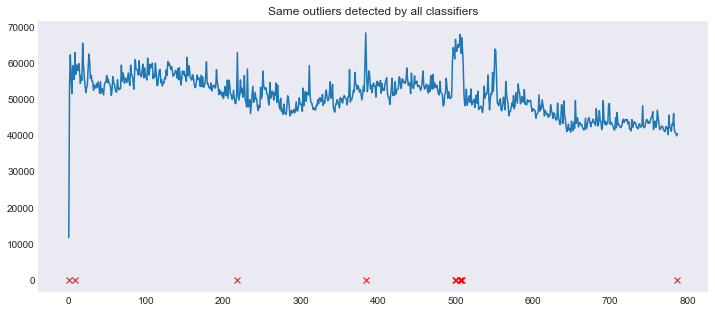

In [21]:
#Show the same detected outliers
fig = plt.figure(figsize=(12, 5))
plt.title('Same outliers detected by all classifiers')
plt.plot(xaxis, yaxis)
plt.scatter(cls_df.index[cls_df['Same Outliers'] == True].array, cls_df['Same Outliers'][cls_df['Same Outliers'] == True], c='red', marker='x', linewidths=1)
plt.show()

<b>UNSW DATASET</b>

In [22]:
#Read column names from a file
unsw_cols = pd.read_csv('./data/UNSW-NB15 - CSV Files/NUSW-NB15_features.csv')

In [23]:
#Read the source csv file for UNSW-NB15 dataset
unsw_df = pd.read_csv('./data/UNSW-NB15 - CSV Files/UNSW-NB15_1.csv', names=unsw_cols['Name'])

c:\users\kuba\python\network-anomaly-detection\venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,3,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
#Create a copy of loaded dataframe for safe modifications
unsw_copy = unsw_df.copy()

In [25]:
#Check the data types of each column
#unsw_copy.dtypes

In [26]:
#Create a column with datetime timestamps (original values are stored as integers)
unsw_copy['Start_time'] = [datetime.datetime.fromtimestamp(x) for x in unsw_copy['Stime']]

In [27]:
#unsw_copy['Start_time']

In [28]:
#Group the dataframe by hour and mintue
unsw_group = unsw_copy.groupby([unsw_copy['Start_time'].dt.hour, unsw_copy['Start_time'].dt.minute]).agg(['count'])

In [29]:
#unsw_group

In [30]:
#Compare size of dataset before and after the grouping operation
print(unsw_copy.shape)
print(unsw_group.shape)

(700001, 50)
(463, 50)


In [31]:
#Set axes for plots
unsw_xaxis = np.arange(unsw_group.shape[0])
unsw_yaxis = unsw_group['Start_time'].values[:,0]

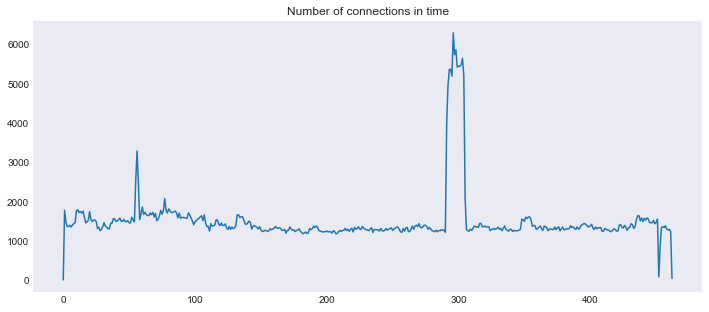

In [32]:
#Plot # of flows
fig = plt.figure(figsize=(12, 5))
plt.plot(unsw_xaxis, unsw_yaxis)
plt.title('Number of connections in time')
plt.show()

In [33]:
#Set model parameters
outlier_fraction = 0.1
unsw_X1 = unsw_xaxis.reshape(-1, 1)
unsw_X2 = unsw_yaxis.reshape(-1, 1)
unsw_X_train = np.concatenate((unsw_X1, unsw_X2), axis=1)
unsw_X_train.shape

(463, 2)

In [34]:
#Define models and their params for outlier detection
classifiers = {
    'Histogram-Based Outlier Score': HBOS(contamination=outlier_fraction),
    'k Nearest Neighbors': KNN(contamination=outlier_fraction),
    #'Average kNN': KNN(method='mean', contamination=outlier_fraction),
    'Clustering Based Local Outlier Factor': CBLOF(contamination=outlier_fraction),
    #'Lightweight On-line Detection of Anomalies': LODA(contamination=outlier_fraction),
    #'Copula Based Outlier Detector': COPOD(contamination=outlier_fraction)
}

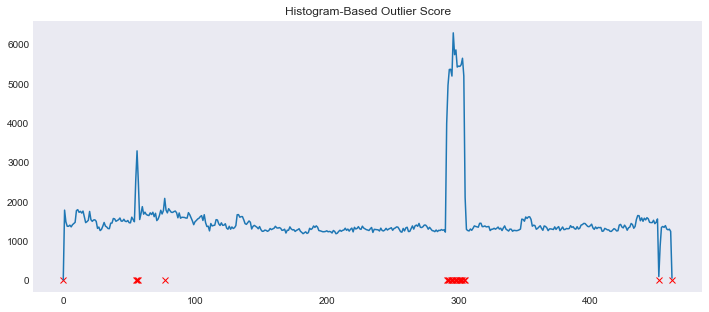

Detection type: Histogram-Based Outlier Score
# of steps: 463
# of detected anomalies: 22
% of detected anomalies: 4.75%


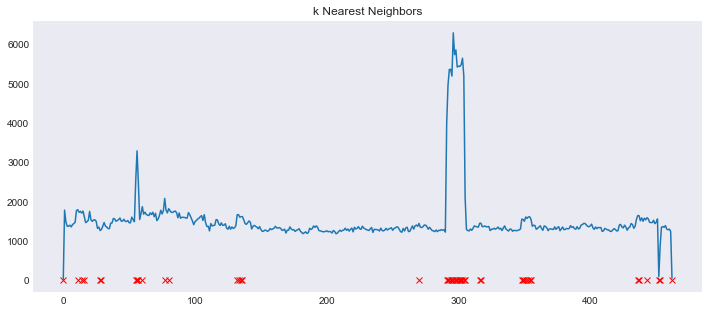

Detection type: k Nearest Neighbors
# of steps: 463
# of detected anomalies: 47
% of detected anomalies: 10.15%


c:\users\kuba\python\network-anomaly-detection\venv\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


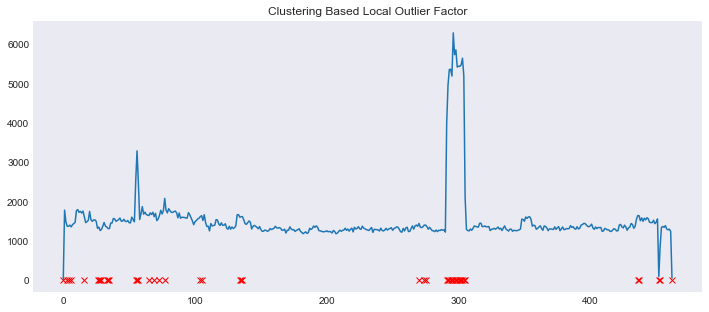

Detection type: Clustering Based Local Outlier Factor
# of steps: 463
# of detected anomalies: 47
% of detected anomalies: 10.15%


In [35]:
#Run every selected model, store their classifier scores inside of a dictionary
unsw_classifier_scores = {}
for clf_name, clf in classifiers.items():
    clf.fit(unsw_X_train)
    y_train_pred = clf.labels_
    y_train_scores = clf.decision_scores_
    scatter = pd.DataFrame([unsw_xaxis, y_train_pred]).T
    logicalscatter = scatter[scatter[1] > 0]
    fig = plt.figure(figsize=(12, 5))
    plt.title(clf_name)
    plt.plot(unsw_xaxis, unsw_yaxis)
    plt.scatter(logicalscatter[0], logicalscatter[1], c='red', marker='x', linewidths=1)
    plt.show()
    outlier_percent = (logicalscatter.shape[0] / unsw_X_train.shape[0]) * 100
    print(f'Detection type: {clf_name}')
    print(f'# of steps: {unsw_X_train.shape[0]}')
    print(f'# of detected anomalies: {logicalscatter.shape[0]}')
    print(f'% of detected anomalies: {outlier_percent:.2f}%')
    unsw_classifier_scores[clf_name] = y_train_pred

In [36]:
#Create a dataframe from classifier scores
unsw_cls_df = pd.DataFrame(unsw_classifier_scores)

In [37]:
#Add a column with sum of each row in the dataframe
unsw_cls_df['Outlier Sum'] = unsw_cls_df.sum(axis=1)

In [38]:
#Create a bool list for the same detected outliers
unsw_same_outliers = []
for row in unsw_cls_df['Outlier Sum']:
    if row == len(unsw_classifier_scores.keys()):
        unsw_same_outliers.append(True)
    else:
        unsw_same_outliers.append(False)

In [39]:
#Add the list to classifier dataframe
unsw_cls_df['Same Outliers'] = unsw_same_outliers

In [40]:
#Calculate % of same outliers
unsw_same_outliers_score = (cls_df['Same Outliers'].sum() / unsw_cls_df.shape[0])
unsw_same_outliers_percent = unsw_same_outliers_score * 100
print(f'Same outlier percentage: {unsw_same_outliers_percent:.2f}%')

Same outlier percentage: 2.16%


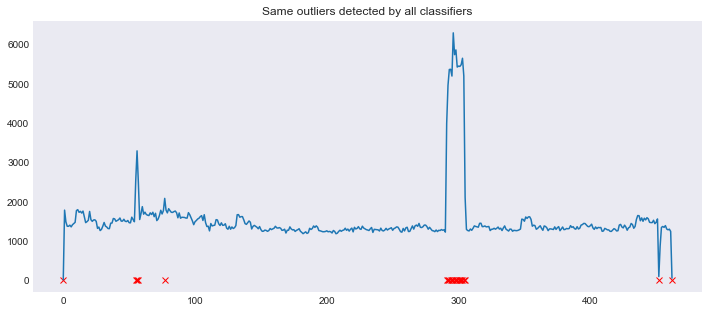

In [41]:
#Show the same detected outliers
fig = plt.figure(figsize=(12, 5))
plt.title('Same outliers detected by all classifiers')
plt.plot(unsw_xaxis, unsw_yaxis)
plt.scatter(unsw_cls_df.index[unsw_cls_df['Same Outliers'] == True].array, unsw_cls_df['Same Outliers'][unsw_cls_df['Same Outliers'] == True], c='red', marker='x', linewidths=1)
plt.show()